In [17]:
import argparse
import contextlib
import dataclasses
import datetime
import itertools
import multiprocessing
import os
import sys
import traceback
from pathlib import Path
from typing import Sequence, cast

import corner  # type: ignore
import emcee  # type: ignore
import numpy as np
import pydantic
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from scipy import optimize, stats  # type: ignore

from cr_knee_fit import experiments
from cr_knee_fit.cr_model import (
    CosmicRaysModel,
    CosmicRaysModelConfig,
    RigidityBreak,
    RigidityBreakConfig,
    SharedPowerLaw,
)
from cr_knee_fit.experiments import Experiment
from cr_knee_fit.fit_data import FitData
from cr_knee_fit.inference import loglikelihood, logposterior, set_global_fit_data
from cr_knee_fit.model import Model, ModelConfig
from cr_knee_fit.plotting import plot_credible_band
from cr_knee_fit.shifts import ExperimentEnergyScaleShifts
from cr_knee_fit.types_ import Primary
from cr_knee_fit.utils import (
    E_GEV_LABEL,
    add_log_margin,
    label_energy_flux,
    legend_with_added_items,
)



In [18]:
E_SCALE = 2.6  # for plots only


def initial_guess_break(bc: RigidityBreakConfig, break_idx: int) -> RigidityBreak:
    if bc.fixed_lg_sharpness:
        lg_s = bc.fixed_lg_sharpness
    else:
        lg_s = stats.norm.rvs(loc=np.log10(5), scale=0.01)

    break_pos_guesses = [4.2, 5.3, 6.5]
    d_alpha_guesses = [0.3, -0.3, 0.5]

    return RigidityBreak(
        lg_R=stats.norm.rvs(loc=break_pos_guesses[break_idx], scale=0.1),
        d_alpha=stats.norm.rvs(loc=d_alpha_guesses[break_idx], scale=0.05),
        lg_sharpness=lg_s,
        fix_sharpness=bc.fixed_lg_sharpness is not None,
    )


initial_guess_lgI = {
    Primary.H: -4,
    Primary.He: -4.65,
    Primary.C: -6.15,
    Primary.O: -6.1,
    Primary.Mg: -6.85,
    Primary.Si: -6.9,
    Primary.Fe: -6.9,
    # Primary.Unobserved: -8,
}


def initial_guess_model(config: ModelConfig) -> Model:
    return Model(
        cr_model=CosmicRaysModel(
            base_spectra=[
                (
                    SharedPowerLaw(
                        lgI_per_primary={
                            primary: stats.norm.rvs(loc=initial_guess_lgI[primary], scale=0.05)
                            for primary in component
                        },
                        alpha=stats.norm.rvs(
                            loc=2.6 if component == [Primary.H] else 2.5,
                            scale=0.05,
                        ),
                    )
                )
                for component in config.cr_model_config.components
            ],
            breaks=[
                initial_guess_break(bc, break_idx=i)
                for i, bc in enumerate(config.cr_model_config.breaks)
            ],
            all_particle_lg_shift=(
                np.log10(stats.uniform.rvs(loc=1.1, scale=0.9))
                if config.cr_model_config.rescale_all_particle
                else None
            ),
            unobserved_component_effective_Z=(
                stats.uniform.rvs(loc=14, scale=26 - 14)
                if config.cr_model_config.add_unobserved_component
                else None
            ),
        ),
        energy_shifts=ExperimentEnergyScaleShifts(
            lg_shifts={exp: stats.norm.rvs(loc=0, scale=0.01) for exp in config.shifted_experiments}
        ),
    )


def safe_initial_guess_model(config: ModelConfig, fit_data: FitData) -> Model:
    n_try = 1000
    for _ in range(n_try):
        m = initial_guess_model(config)
        if np.isfinite(logposterior(m, fit_data, config)):
            return m
    else:
        raise ValueError(f"Failed to generate valid model in {n_try} tries")


class FitConfig(pydantic.BaseModel):
    name: str
    experiments_detailed: list[Experiment]
    experiments_all_particle: list[Experiment]
    experiments_lnA: list[Experiment]
    model: ModelConfig


def print_delim():
    print(
        "\n\n"
        + "=" * 15
        + "\n"
        + datetime.datetime.now().isoformat(sep=" ", timespec="seconds")
        + "\n\n"
    )


def load_fit_data(config: FitConfig) -> FitData:
    return FitData.load(
        experiments_detailed=config.experiments_detailed,
        experiments_all_particle=config.experiments_all_particle,
        experiments_lnA=config.experiments_lnA,
        primaries=config.model.cr_model_config.primaries,
        R_bounds=(7e2, 1e8),
    )


def run_mle(config: FitConfig) -> Model:
    fit_data = load_fit_data(config)

    mle_config = dataclasses.replace(config.model, shifted_experiments=[])

    def negloglike(v: np.ndarray) -> float:
        return -loglikelihood(v, fit_data, mle_config)

    res = optimize.minimize(
        negloglike,
        x0=safe_initial_guess_model(mle_config, fit_data).pack(),
        method="Nelder-Mead",
        options={
            "maxiter": 100_000,
        },
    )
    print(res)
    mle_model = Model.unpack(res.x, layout_info=mle_config)
    fig = mle_model.plot(fit_data, scale=E_SCALE)
    mle_model.print_params()
    fig.show()
    return mle_model

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 57.14067420240959
             x: [-4.101e+00  2.619e+00 ...  5.422e+00 -2.629e-01]
           nit: 1997
          nfev: 2694
 final_simplex: (array([[-4.101e+00,  2.619e+00, ...,  5.422e+00,
                        -2.629e-01],
                       [-4.101e+00,  2.619e+00, ...,  5.422e+00,
                        -2.629e-01],
                       ...,
                       [-4.101e+00,  2.619e+00, ...,  5.422e+00,
                        -2.629e-01],
                       [-4.101e+00,  2.619e+00, ...,  5.422e+00,
                        -2.629e-01]]), array([ 5.714e+01,  5.714e+01, ...,  5.714e+01,  5.714e+01]))
  1.                          lgI_{H} = -4.10e+00
  2.                        alpha_{H} = 2.62e+00
  3.                         lgI_{He} = -4.66e+00
  4.                       alpha_{He} = 2.51e+00
  5.                          lgI_{C} = -6.18e+00
  6.            

/var/folders/pt/5p7r1p1j49n8f_88l1j7jtwc0000gn/T/ipykernel_65889/1884567950.py:130: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


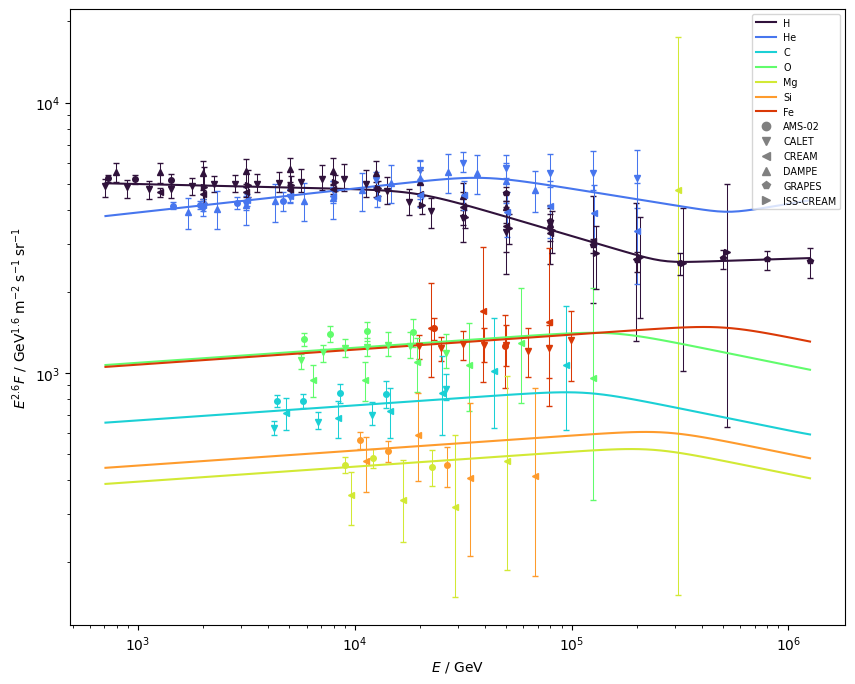

In [19]:
experiments_detailed = experiments.direct_experiments + [experiments.grapes]

mle_config = FitConfig(
    name="",
    experiments_detailed=experiments_detailed,
    experiments_all_particle=[],
    experiments_lnA=[],
    model=ModelConfig(
        cr_model_config=CosmicRaysModelConfig(
            components=[
                [Primary.H],
                [Primary.He],
                [
                    Primary.C,
                    Primary.O,
                    Primary.Mg,
                    Primary.Si,
                    Primary.Fe,
                ],
            ],
            breaks=[
                RigidityBreakConfig(fixed_lg_sharpness=np.log10(5)),
                RigidityBreakConfig(fixed_lg_sharpness=np.log10(10)),
            ],
            rescale_all_particle=False,
        ),
        shifted_experiments=[e for e in experiments_detailed if e != experiments.ams02],
    ),
)

mle_model = run_mle(mle_config)

# Fits on top of the fixed composition model

Data by primary:
AMS-02
  H: 3 points from 7.3e+02 to 1.4e+03 GeV
  He: 4 points from 1.5e+03 to 4.6e+03 GeV
  C: 4 points from 4.4e+03 to 1.4e+04 GeV
  O: 4 points from 5.8e+03 to 1.9e+04 GeV
  Mg: 3 points from 9.0e+03 to 2.3e+04 GeV
  Si: 3 points from 1.1e+04 to 2.7e+04 GeV
  Fe: 2 points from 2.3e+04 to 4.9e+04 GeV
CALET
  H: 18 points from 7.1e+02 to 5.0e+04 GeV
  He: 11 points from 2.0e+03 to 2.0e+05 GeV
  C: 4 points from 4.3e+03 to 2.6e+04 GeV
  O: 7 points from 5.7e+03 to 2.6e+04 GeV
  Fe: 8 points from 2.0e+04 to 1.0e+05 GeV
DAMPE
  H: 11 points from 7.9e+02 to 7.9e+04 GeV
  He: 13 points from 1.7e+03 to 6.8e+04 GeV
CREAM
  H: 12 points from 1.3e+03 to 2.0e+05 GeV
  He: 11 points from 2.0e+03 to 2.0e+05 GeV
  C: 6 points from 4.8e+03 to 9.4e+04 GeV
  O: 6 points from 6.4e+03 to 1.3e+05 GeV
  Mg: 5 points from 9.6e+03 to 3.1e+05 GeV
  Si: 4 points from 1.1e+04 to 6.8e+04 GeV
  Fe: 3 points from 2.2e+04 to 7.9e+04 GeV
ISS-CREAM
  H: 13 points from 2.0e+03 to 5.2e+05 GeV
GRAPES

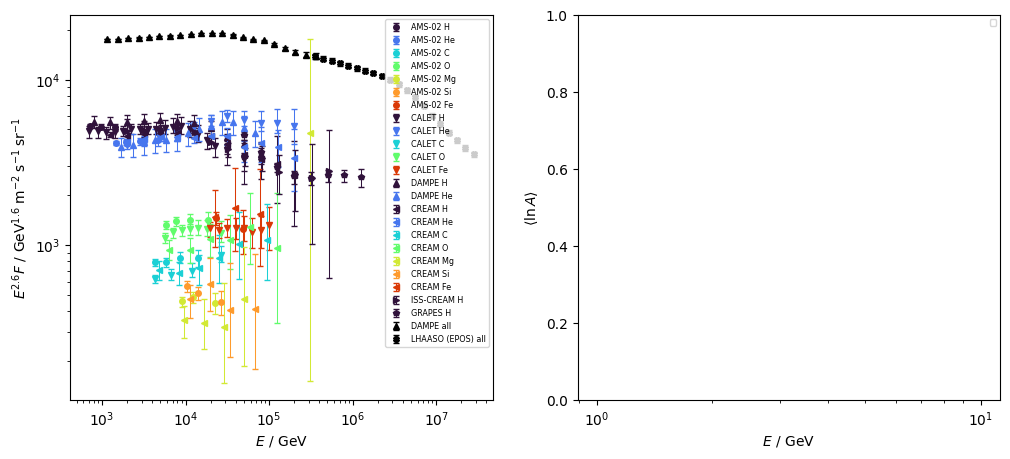

In [20]:
import copy


full_config = copy.deepcopy(mle_config)
full_config.experiments_all_particle = [
    experiments.dampe,
    experiments.lhaaso_epos,
]
# full_config.experiments_lnA = [experiments.lhaaso_epos]
full_fit_data = load_fit_data(full_config)

full_fit_data.plot(scale=2.6, describe=True)


def model_with_unobserved(theta: np.ndarray) -> Model:
    # lgI, Z, lgR_knee, d_alpha_knee, lg_s = theta
    lgI, Z, lgR_knee, d_alpha_knee = theta
    model = copy.deepcopy(mle_model)
    model.cr_model.unobserved_component_effective_Z = Z
    [s for s in model.cr_model.base_spectra if len(s.lgI_per_primary) > 1][0].lgI_per_primary[
        Primary.Unobserved
    ] = lgI
    model.cr_model.breaks.append(
        RigidityBreak(
            lg_R=lgR_knee,
            d_alpha=d_alpha_knee,
            # lg_sharpness=lg_s,
            lg_sharpness=np.log10(5),
        )
    )
    return model


def negloglike(theta: np.ndarray) -> float:
    return -loglikelihood(
        model_with_unobserved(theta),
        full_fit_data,
        None,  # type: ignore
    )

In [23]:
res = optimize.minimize(
    negloglike,
    x0=np.array(
        [
            -5.3,
            4.0,
            6.0,
            0.8,
            # np.log10(5),
        ]
    ),
    bounds=[
        (None, None),
        (3.0, 26.0),
        (6.0, 8.0),
        (None, None),
        # (None, None),
        # (np.log10(0.1), np.log10(20.0)),
    ],
    method="Nelder-Mead",
    # options={
    # "maxiter": 100_000,
    # },
)
print(res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 607.5523606036985
             x: [-4.871e+00  3.000e+00  6.000e+00  1.022e+00]
           nit: 222
          nfev: 370
 final_simplex: (array([[-4.871e+00,  3.000e+00,  6.000e+00,  1.022e+00],
                       [-4.871e+00,  3.000e+00,  6.000e+00,  1.022e+00],
                       ...,
                       [-4.871e+00,  3.000e+00,  6.000e+00,  1.022e+00],
                       [-4.871e+00,  3.000e+00,  6.000e+00,  1.022e+00]]), array([ 6.076e+02,  6.076e+02,  6.076e+02,  6.076e+02,
                        6.076e+02]))


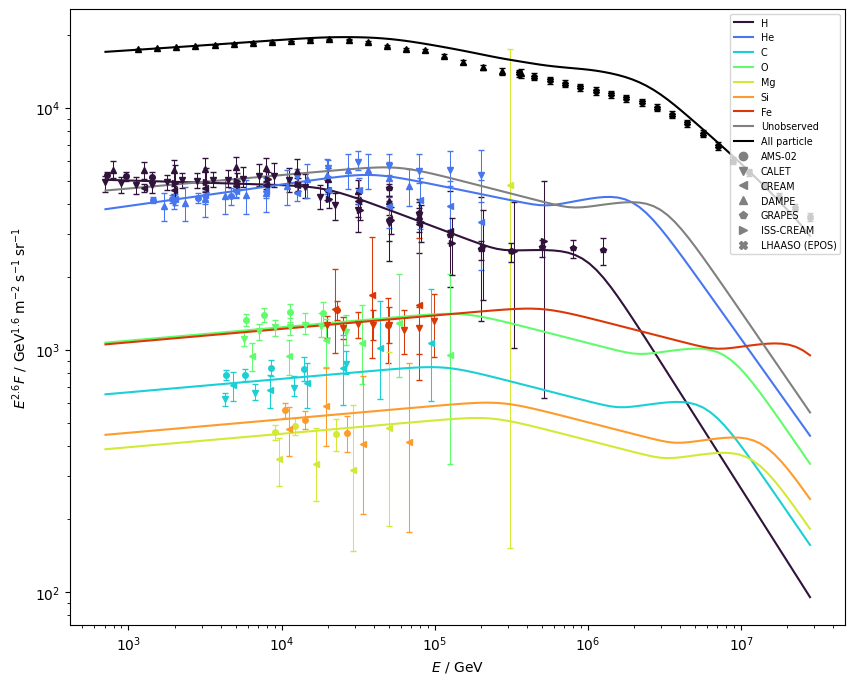

In [24]:
_ = model_with_unobserved(res.x).plot(full_fit_data, scale=2.6)